In [1]:
import sys, os
sys.path.insert(0, '../')
sys.path.insert(0, '../python_src/')

import numpy as np
import scipy as sp
import numpy.random as rand
import numpy.linalg as la
import gzip
import cPickle as pickle
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
import networkx as nx
import itertools as it
%matplotlib inline

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib import collections as mc

import mech_network_solver as mns
import network
import tuning_algs as talgs
import network_plot as nplot

Loading Mechanical Network Deformation Solver Module


In [31]:
DIM = 2

NN = 512
Lp = -1.0
irec = 122
Delta = 1.0
NTS = 16


NDISC = 1.0

rand.seed(irec)


# nw_label = "networks_spring_disc_3/db_N00008192_Lp-1.40/N00008192_Lp-1.40_radius0.08838835"
# net = network.loadFiniteRandomNetwork(nw_label, irec)
# com = net.L / 2.0

# net.L *= 1.2

# for i in range(net.NN):
#     net.node_pos[2*i:2*i+2] += net.L/2 - com 



nw_label = "network_periodic_jammed/network_N{:05d}_Lp{:.2f}/network_irec{:04d}".format(NN, Lp, irec)

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 


NF = 1


edgei = net.edgei
edgej = net.edgej


inodesi = [[] for t in range(NF)]
inodesj = [[] for t in range(NF)]
istrain_bonds = [[] for t in range(NF)]

onodesi = [[] for t in range(NF)]
onodesj = [[] for t in range(NF)]
ostrain_bonds = [[] for t in range(NF)]



##################################################

L = np.copy(net.L)

pos = np.array([0.5*L[0], 0.5*L[1]])
s = network.closestEdge(net, pos)[0]


inodesi[0].append(edgei[s])
inodesj[0].append(edgej[s])
istrain_bonds[0].append(s)

# pos = np.array([0.9*L[0], 0.5*L[1]])
# b = network.closestEdge(net, pos)[0]

# onodesi[0].append(edgei[b])
# onodesj[0].append(edgej[b])
# ostrain_bonds[0].append(b)
    
edge = range(net.NE)

rand.shuffle(edge)

for i in range(NTS):
    b = edge.pop()

    onodesi[0].append(edgei[b])
    onodesj[0].append(edgej[b])
    ostrain_bonds[0].append(b)

######################################################


isvec = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(inodesi[t], inodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        isvec[t].extend(bvec) 

istrain = [[] for t in range(NF)]
istrain[0].append(1.0)


osvec = [[] for t in range(NF)]
ostrain = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(onodesi[t], onodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        osvec[t].extend(bvec) 


        ostrain[t].append(Delta)

pert = []
meas = []
for t in range(NF):
    pert.append(talgs.Perturb())
#     pert[t].setInputStress(len(istrain_bonds[t]), istrain_bonds[t], istrain[t])
    pert[t].setInputStrain(len(inodesi[t]), inodesi[t], inodesj[t], istrain_bonds[t], istrain[t], isvec[t])

    meas.append(talgs.Measure())
#     meas[t].setOutputStress(len(ostrain_bonds[t]), ostrain_bonds[t])
    meas[t].setOutputStrain(len(onodesi[t]), onodesi[t], onodesj[t], ostrain_bonds[t], osvec[t])

obj_func = mns.CyIneqRatioChangeObjFunc(len(np.concatenate(ostrain)), net.NE, 
                                        np.zeros(len(np.concatenate(ostrain)), float), np.concatenate(ostrain),
                                       relative=False, change=False)    



In [32]:
K_max = np.ones(net.NE, float) / net.eq_length

K_disc = np.ones(net.NE, float)


tuner = talgs.TuneDiscLin(net, pert, meas, obj_func, K_max, K_disc, NDISC=NDISC)

data = tuner.tune()

print data


tuner.solver.setIntStrengths(data['K'])
(disp, strain) = tuner.solver.solveDOF()
data['disp'] = disp[0]

tuner.solver.setIntStrengths(K_max)
(disp, strain) = tuner.solver.solveDOF()
data['disp_init'] = disp[0]

Initial objective function: 8.04466282356
Removing 0 / 1416.0 / 1416 bonds would create zero modes...
{'disc': 0.0, 'bond': 695}
0 Objective function: 7.97797015585 Change: -0.0666926677101 Percent: -0.829029993834 %
Removing 0 / 1415.0 / 1416 bonds would create zero modes...
{'disc': 0.0, 'bond': 694}
1 Objective function: 7.86273251615 Change: -0.115237639701 Percent: -1.44444811713 %
Removing 1 / 1414.0 / 1416 bonds would create zero modes...
{'disc': 0.0, 'bond': 685}
2 Objective function: 7.69762271739 Change: -0.165109798761 Percent: -2.09990354399 %
Removing 1 / 1413.0 / 1416 bonds would create zero modes...
{'disc': 0.0, 'bond': 684}
3 Objective function: 7.53027183107 Change: -0.167350886326 Percent: -2.17405934884 %
Removing 3 / 1412.0 / 1416 bonds would create zero modes...
{'disc': 0.0, 'bond': 703}
4 Objective function: 7.49947319818 Change: -0.0307986328819 Percent: -0.408997624161 %
Removing 3 / 1411.0 / 1416 bonds would create zero modes...
{'disc': 0.0, 'bond': 740}
5 

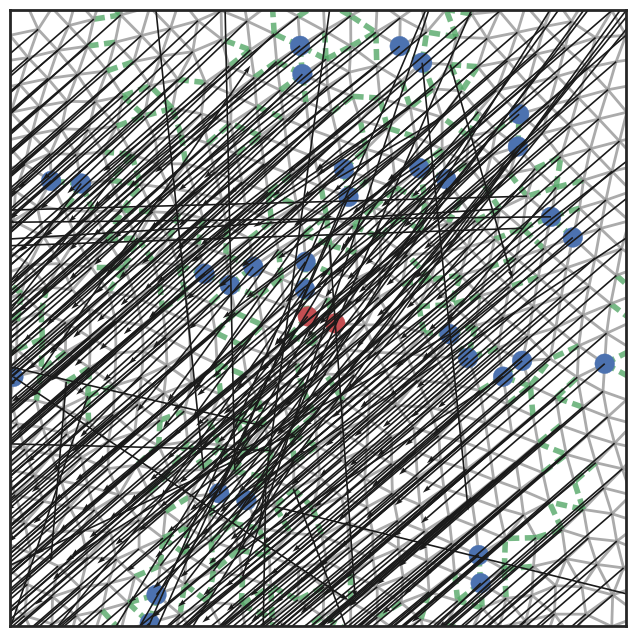

In [33]:
mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='deep')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

disp = data['disp']
removed = np.where(data['K_disc'] == 0.0)[0]



styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))
    styles[edge]['color'] = 'g'
    styles[edge]['lw'] = 4.0
    
nplot.show_network(ax1, net, styles=styles)

styles = {}
for i in inodesi[0]:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj[0]:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi[0]:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj[0]:
    styles[i] = {}
    styles[i]['color'] = 'b'

nplot.show_nodes(ax1, net, styles.keys(), styles=styles)

nplot.show_vecs(ax1, net, disp)


ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

# # plt.savefig("talk_figs/tuned_mech_input_extension_displacement.png")
# plt.savefig("talk_figs/tuned_mech_input_tension_displacement.png")


plt.savefig("talk_figs/tuned_mech_input_extension_displacement_NTS{:03d}.png".format(NTS))

plt.show()

In [31]:
DIM = 2

NN = 512
Lp = -1.0
irec = 100
Delta = 1.0
NTS = 1


NDISC = 1.0

rand.seed(irec)


nw_label = "networks_spring_disc_3/db_N00008192_Lp-1.40/N00008192_Lp-1.40_radius0.08838835"
net = network.loadFiniteRandomNetwork(nw_label, irec)
com = net.L / 2.0

net.L *= 1.2

for i in range(net.NN):
    net.node_pos[2*i:2*i+2] += net.L/2 - com 



# nw_label = "network_periodic_jammed/network_N{:05d}_Lp{:.2f}/network_irec{:04d}".format(NN, Lp, irec)

# with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

#     nw_data = pickle.load(pkl_file)
#     net = nw_data['network'] 


NF = 1


edgei = net.edgei
edgej = net.edgej


inodesi = [[] for t in range(NF)]
inodesj = [[] for t in range(NF)]
istrain_bonds = [[] for t in range(NF)]

onodesi = [[] for t in range(NF)]
onodesj = [[] for t in range(NF)]
ostrain_bonds = [[] for t in range(NF)]



##################################################

L = np.copy(net.L)

pos = np.array([0.1*L[0], 0.5*L[1]])
s = network.closestEdge(net, pos)[0]


inodesi[0].append(edgei[s])
inodesj[0].append(edgej[s])
istrain_bonds[0].append(s)

pos = np.array([0.9*L[0], 0.5*L[1]])
b = network.closestEdge(net, pos)[0]

onodesi[0].append(edgei[b])
onodesj[0].append(edgej[b])
ostrain_bonds[0].append(b)
    
# edge = range(net.NE)

# rand.shuffle(edge)

# for i in range(NTS):
#     b = edge.pop()

#     onodesi[0].append(edgei[b])
#     onodesj[0].append(edgej[b])
#     ostrain_bonds[0].append(b)

######################################################


isvec = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(inodesi[t], inodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        isvec[t].extend(bvec) 

istrain = [[] for t in range(NF)]
istrain[0].append(1.0)


osvec = [[] for t in range(NF)]
ostrain = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(onodesi[t], onodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        osvec[t].extend(bvec) 


        ostrain[t].append(Delta)

pert = []
meas = []
for t in range(NF):
    pert.append(talgs.Perturb())
#     pert[t].setInputStress(len(istrain_bonds[t]), istrain_bonds[t], istrain[t])
    pert[t].setInputStrain(len(inodesi[t]), inodesi[t], inodesj[t], istrain_bonds[t], istrain[t], isvec[t])

    meas.append(talgs.Measure())
#     meas[t].setOutputStress(len(ostrain_bonds[t]), ostrain_bonds[t])
    meas[t].setOutputStrain(len(onodesi[t]), onodesi[t], onodesj[t], ostrain_bonds[t], osvec[t])

obj_func = mns.CyIneqRatioChangeObjFunc(len(np.concatenate(ostrain)), net.NE, 
                                        np.zeros(len(np.concatenate(ostrain)), float), np.concatenate(ostrain),
                                       relative=False, change=False)    



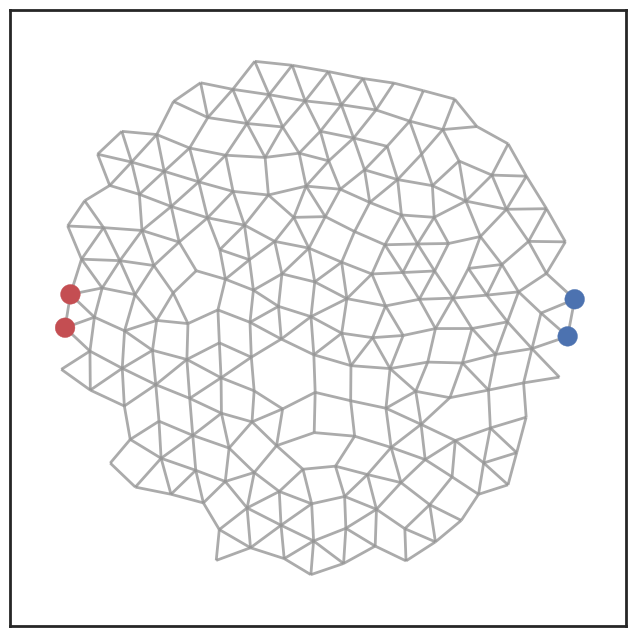

In [3]:
mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='deep')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)


styles = {edge: {} for edge in range(net.NE)}
    
nplot.show_network(ax1, net, styles=styles)

styles = {}
for i in inodesi[0]:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj[0]:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi[0]:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj[0]:
    styles[i] = {}
    styles[i]['color'] = 'b'

nplot.show_nodes(ax1, net, styles.keys(), styles=styles)

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

plt.savefig("talk_figs/plain_network.png")

plt.show()

In [12]:
K_max = np.ones(net.NE, float) / net.eq_length

K_disc = np.ones(net.NE, float)


tuner = talgs.TuneDiscLin(net, pert, meas, obj_func, K_max, K_disc, NDISC=NDISC)

data = tuner.tune()

print data


tuner.solver.setIntStrengths(data['K'])
(disp, strain) = tuner.solver.solveDOF()
data['disp'] = disp[0]

tuner.solver.setIntStrengths(K_max)
(disp, strain) = tuner.solver.solveDOF()
data['disp_init'] = disp[0]

Initial objective function: 0.993548861685
Removing 0 / 1417.0 / 1417 bonds would create zero modes...
{'disc': 0.0, 'bond': 792}
0 Objective function: 0.97221100987 Change: -0.0213378518151 Percent: -2.14763990357 %
Removing 0 / 1416.0 / 1417 bonds would create zero modes...
{'disc': 0.0, 'bond': 715}
1 Objective function: 0.946287651554 Change: -0.0259233583161 Percent: -2.66643332085 %
Removing 0 / 1415.0 / 1417 bonds would create zero modes...
{'disc': 0.0, 'bond': 736}
2 Objective function: 0.916004858021 Change: -0.0302827935333 Percent: -3.2001678859 %
Removing 0 / 1414.0 / 1417 bonds would create zero modes...
{'disc': 0.0, 'bond': 699}
3 Objective function: 0.874718504687 Change: -0.041286353334 Percent: -4.50721990964 %
Removing 0 / 1413.0 / 1417 bonds would create zero modes...
{'disc': 0.0, 'bond': 1020}
4 Objective function: 0.82072191627 Change: -0.0539965884164 Percent: -6.1730245933 %
Removing 0 / 1412.0 / 1417 bonds would create zero modes...
{'disc': 0.0, 'bond': 778}

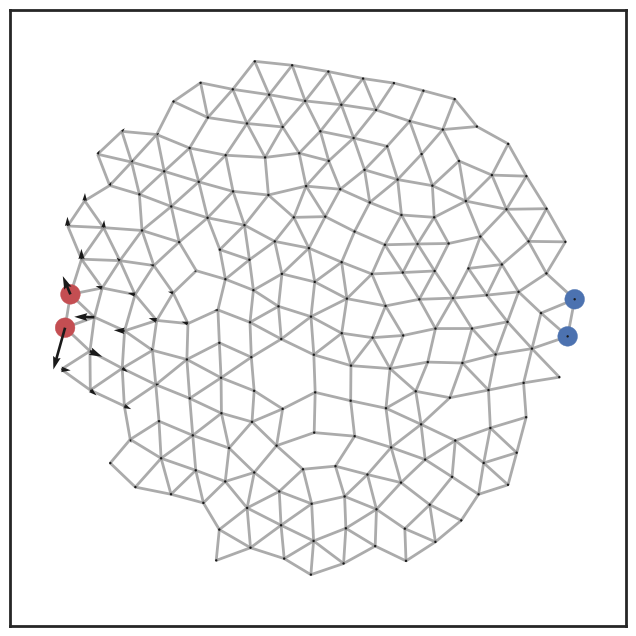

In [23]:
mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='deep')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

disp = data['disp_init']


styles = {edge: {} for edge in range(net.NE)}
    
nplot.show_network(ax1, net, styles=styles)

styles = {}
for i in inodesi[0]:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj[0]:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi[0]:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj[0]:
    styles[i] = {}
    styles[i]['color'] = 'b'

nplot.show_nodes(ax1, net, styles.keys(), styles=styles)

nplot.show_vecs(ax1, net, 2.0*disp)


ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])


# plt.savefig("talk_figs/init_mech_input_extension_displacement.png")
plt.savefig("talk_figs/init_mech_input_tension_displacement.png")


plt.show()

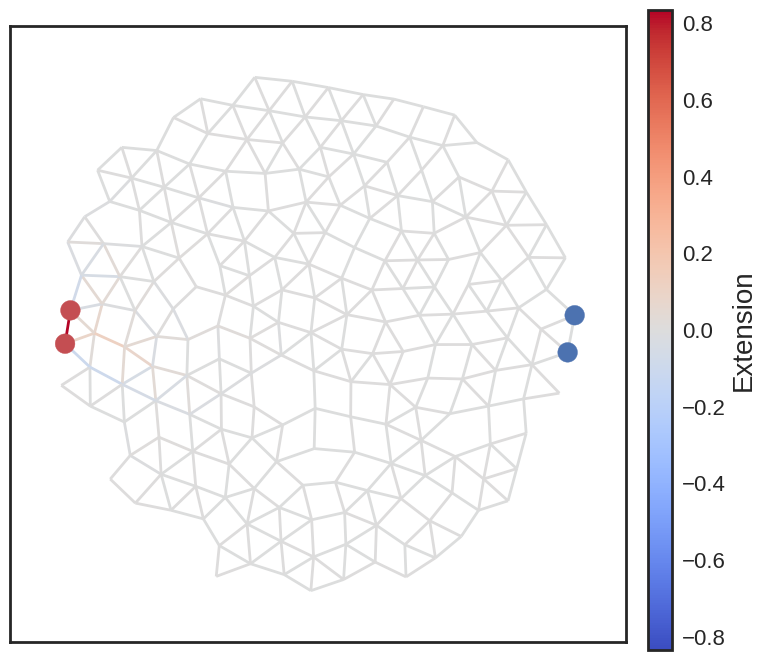

In [24]:
def calc_ext(net, disp):
    edgei = np.copy(net.edgei)
    edgej = np.copy(net.edgej)
    node_pos = np.copy(net.node_pos)
    DIM = net.DIM
    NE = net.NE
    NN = net.NN
    L = np.copy(net.L)
    
    ext = np.zeros(NE, float)
    for i in range(NE):
        
        posi = node_pos[DIM*edgei[i]:DIM*edgei[i]+DIM]
        posj = node_pos[DIM*edgej[i]:DIM*edgej[i]+DIM]

        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        
        bhat = bvec / la.norm(bvec)
        
        dispi = disp[DIM*edgei[i]:DIM*edgei[i]+DIM]
        dispj = disp[DIM*edgej[i]:DIM*edgej[i]+DIM]
        
        ext[i] = bhat.dot(dispj - dispi)
        
    return ext

mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='deep')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

disp = data['disp_init']


styles = {edge: {} for edge in range(net.NE)}
    
ext = calc_ext(net, disp)
        
limit = np.max([np.abs(np.min(ext)), np.abs(np.max(ext))])
norm = mcolors.Normalize(vmin=-limit, vmax=limit)
# norm = mcolors.Normalize(vmin=np.min(ext), vmax=np.max(ext))
cmap = mpl.cm.coolwarm
smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

for edge in range(net.NE):
    styles[edge]['color'] = smap.to_rgba(ext[edge])    
    
    
nplot.show_network(ax1, net, styles=styles, alpha=1.0)

styles = {}
for i in inodesi[0]:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj[0]:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi[0]:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj[0]:
    styles[i] = {}
    styles[i]['color'] = 'b'

nplot.show_nodes(ax1, net, styles.keys(), styles=styles)

# nplot.show_vecs(ax1, net, disp)


cax = fig.add_axes([0.925, 0.10, 0.03, 0.80])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')

cbar.ax.tick_params(labelsize=16) 
cbar.set_label("Extension", fontdict={'fontsize': 20})

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])


# plt.savefig("talk_figs/init_mech_input_extension_extension.png")
plt.savefig("talk_figs/init_mech_input_tension_extension.png")


plt.show()

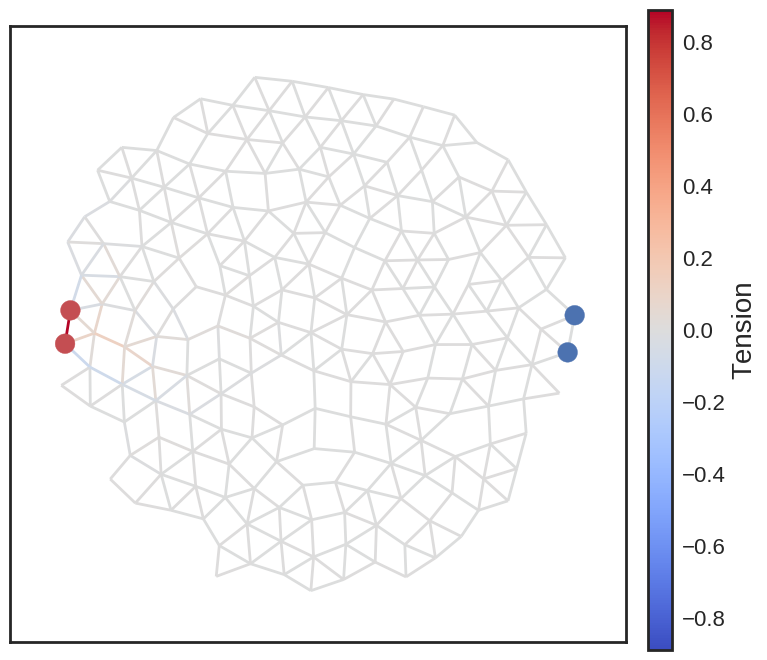

In [25]:
def calc_ext(net, disp):
    edgei = np.copy(net.edgei)
    edgej = np.copy(net.edgej)
    node_pos = np.copy(net.node_pos)
    DIM = net.DIM
    NE = net.NE
    NN = net.NN
    L = np.copy(net.L)
    
    ext = np.zeros(NE, float)
    for i in range(NE):
        
        posi = node_pos[DIM*edgei[i]:DIM*edgei[i]+DIM]
        posj = node_pos[DIM*edgej[i]:DIM*edgej[i]+DIM]

        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        
        bhat = bvec / la.norm(bvec)
        
        dispi = disp[DIM*edgei[i]:DIM*edgei[i]+DIM]
        dispj = disp[DIM*edgej[i]:DIM*edgej[i]+DIM]
        
        ext[i] = bhat.dot(dispj - dispi)
        
    return ext

mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='deep')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

disp = data['disp_init']


styles = {edge: {} for edge in range(net.NE)}
    
tension = calc_ext(net, disp) * K_max
        
limit = np.max([np.abs(np.min(tension)), np.abs(np.max(tension))])
norm = mcolors.Normalize(vmin=-limit, vmax=limit)
# norm = mcolors.Normalize(vmin=np.min(ext), vmax=np.max(ext))
cmap = mpl.cm.coolwarm
smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

for edge in range(net.NE):
    styles[edge]['color'] = smap.to_rgba(tension[edge])    
    
    
nplot.show_network(ax1, net, styles=styles, alpha=1.0)

styles = {}
for i in inodesi[0]:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj[0]:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi[0]:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj[0]:
    styles[i] = {}
    styles[i]['color'] = 'b'

nplot.show_nodes(ax1, net, styles.keys(), styles=styles)

# nplot.show_vecs(ax1, net, disp)


cax = fig.add_axes([0.925, 0.10, 0.03, 0.80])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')

cbar.ax.tick_params(labelsize=16) 
cbar.set_label("Tension", fontdict={'fontsize': 20})

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])


# plt.savefig("talk_figs/init_mech_input_extension_tension.png")
plt.savefig("talk_figs/init_mech_input_tension_tension.png")


plt.show()

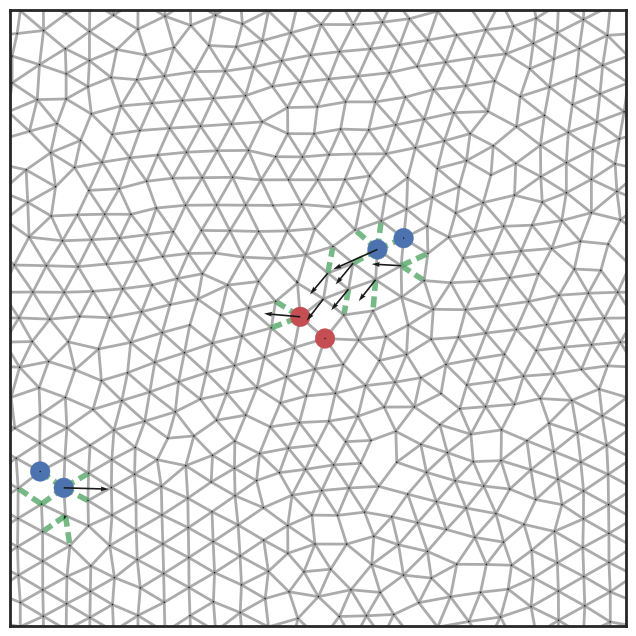

In [14]:
mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='deep')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

disp = data['disp']
removed = np.where(data['K_disc'] == 0.0)[0]



styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))
    styles[edge]['color'] = 'g'
    styles[edge]['lw'] = 4.0
    
nplot.show_network(ax1, net, styles=styles)

styles = {}
for i in inodesi[0]:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj[0]:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi[0]:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj[0]:
    styles[i] = {}
    styles[i]['color'] = 'b'

nplot.show_nodes(ax1, net, styles.keys(), styles=styles)

nplot.show_vecs(ax1, net, disp)


ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

# # plt.savefig("talk_figs/tuned_mech_input_extension_displacement.png")
# plt.savefig("talk_figs/tuned_mech_input_tension_displacement.png")

plt.show()

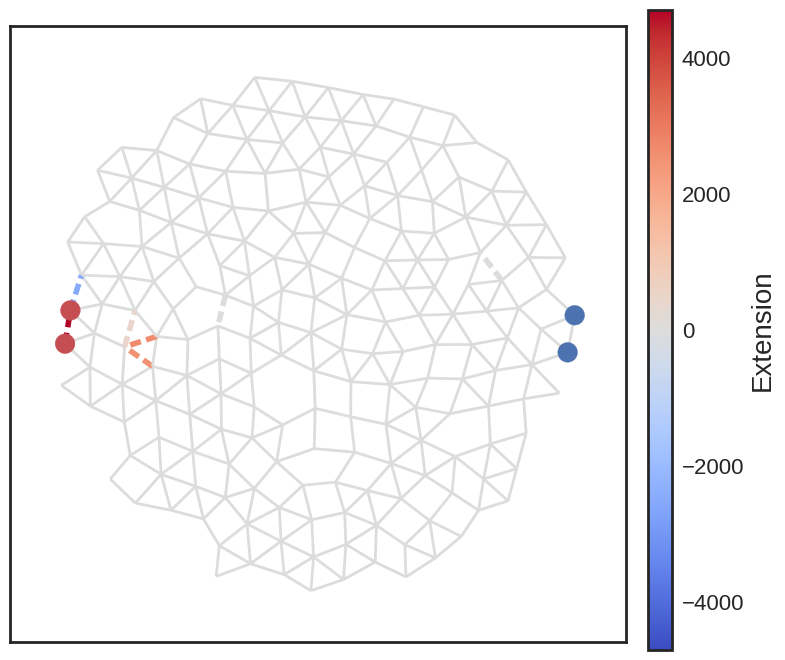

In [29]:
def calc_ext(net, disp):
    edgei = np.copy(net.edgei)
    edgej = np.copy(net.edgej)
    node_pos = np.copy(net.node_pos)
    DIM = net.DIM
    NE = net.NE
    NN = net.NN
    L = np.copy(net.L)
    
    ext = np.zeros(NE, float)
    for i in range(NE):
        
        posi = node_pos[DIM*edgei[i]:DIM*edgei[i]+DIM]
        posj = node_pos[DIM*edgej[i]:DIM*edgej[i]+DIM]

        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        
        bhat = bvec / la.norm(bvec)
        
        dispi = disp[DIM*edgei[i]:DIM*edgei[i]+DIM]
        dispj = disp[DIM*edgej[i]:DIM*edgej[i]+DIM]
        
        ext[i] = bhat.dot(dispj - dispi)
        
    return ext

mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='deep')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

disp = data['disp']


styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))
    styles[edge]['lw'] = 4.0
    
ext = calc_ext(net, disp)
        
limit = np.max([np.abs(np.min(ext)), np.abs(np.max(ext))])
norm = mcolors.Normalize(vmin=-limit, vmax=limit)
# norm = mcolors.Normalize(vmin=np.min(ext), vmax=np.max(ext))
cmap = mpl.cm.coolwarm
smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

for edge in range(net.NE):
    styles[edge]['color'] = smap.to_rgba(ext[edge])    
    
    
nplot.show_network(ax1, net, styles=styles, alpha=1.0)

styles = {}
for i in inodesi[0]:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj[0]:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi[0]:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj[0]:
    styles[i] = {}
    styles[i]['color'] = 'b'

nplot.show_nodes(ax1, net, styles.keys(), styles=styles)

# nplot.show_vecs(ax1, net, disp)


cax = fig.add_axes([0.925, 0.10, 0.03, 0.80])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')

cbar.ax.tick_params(labelsize=16) 
cbar.set_label("Extension", fontdict={'fontsize': 20})

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])


# plt.savefig("talk_figs/tuned_mech_input_extension_extension.png")
plt.savefig("talk_figs/tuned_mech_input_tension_extension.png")

plt.show()

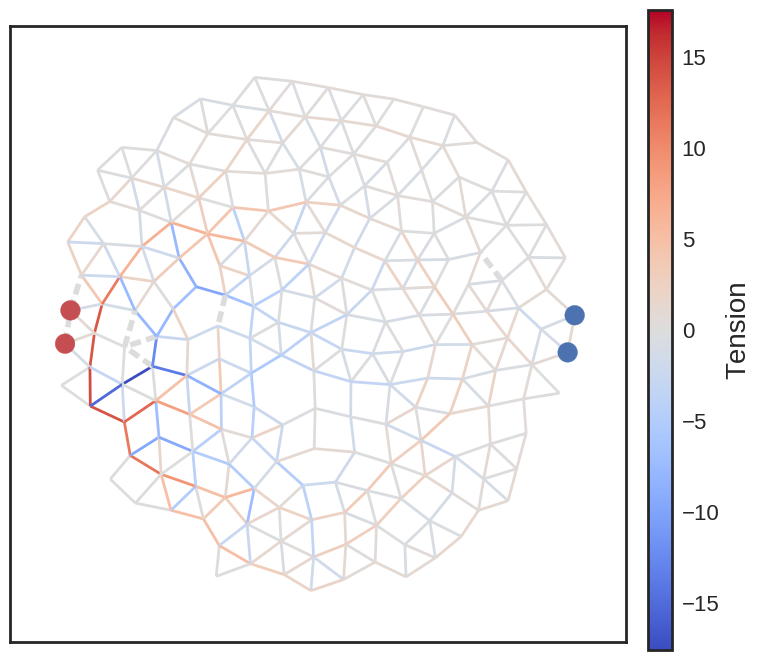

In [30]:
def calc_ext(net, disp):
    edgei = np.copy(net.edgei)
    edgej = np.copy(net.edgej)
    node_pos = np.copy(net.node_pos)
    DIM = net.DIM
    NE = net.NE
    NN = net.NN
    L = np.copy(net.L)
    
    ext = np.zeros(NE, float)
    for i in range(NE):
        
        posi = node_pos[DIM*edgei[i]:DIM*edgei[i]+DIM]
        posj = node_pos[DIM*edgej[i]:DIM*edgej[i]+DIM]

        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        
        bhat = bvec / la.norm(bvec)
        
        dispi = disp[DIM*edgei[i]:DIM*edgei[i]+DIM]
        dispj = disp[DIM*edgej[i]:DIM*edgej[i]+DIM]
        
        ext[i] = bhat.dot(dispj - dispi)
        
    return ext

mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='deep')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

disp = data['disp']


styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))
    styles[edge]['lw'] = 4.0
    
tension = calc_ext(net, disp) * data['K']
        
limit = np.max([np.abs(np.min(tension)), np.abs(np.max(tension))])
norm = mcolors.Normalize(vmin=-limit, vmax=limit)
# norm = mcolors.Normalize(vmin=np.min(ext), vmax=np.max(ext))
cmap = mpl.cm.coolwarm
smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

for edge in range(net.NE):
    styles[edge]['color'] = smap.to_rgba(tension[edge])    
    
    
nplot.show_network(ax1, net, styles=styles, alpha=1.0)

styles = {}
for i in inodesi[0]:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj[0]:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi[0]:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj[0]:
    styles[i] = {}
    styles[i]['color'] = 'b'

nplot.show_nodes(ax1, net, styles.keys(), styles=styles)

# nplot.show_vecs(ax1, net, disp)


cax = fig.add_axes([0.925, 0.10, 0.03, 0.80])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')

cbar.ax.tick_params(labelsize=16) 
cbar.set_label("Tension", fontdict={'fontsize': 20})

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])


# plt.savefig("talk_figs/tuned_mech_input_extension_tension.png")
plt.savefig("talk_figs/tuned_mech_input_tension_tension.png")


plt.show()

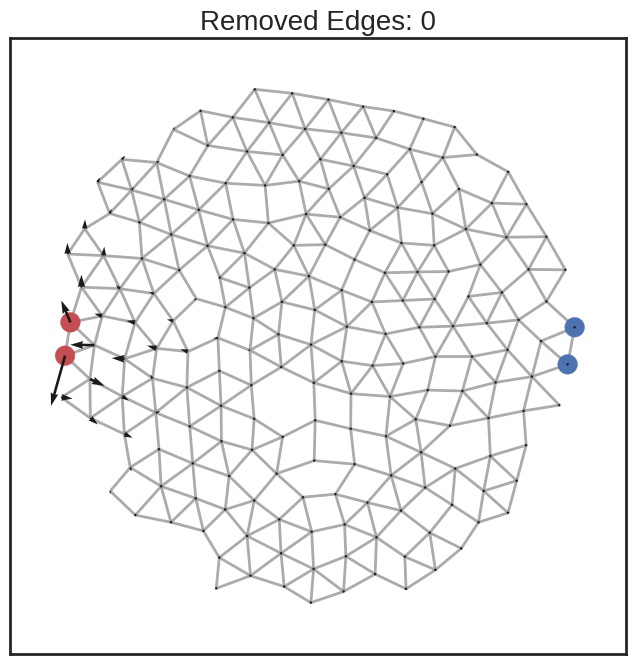

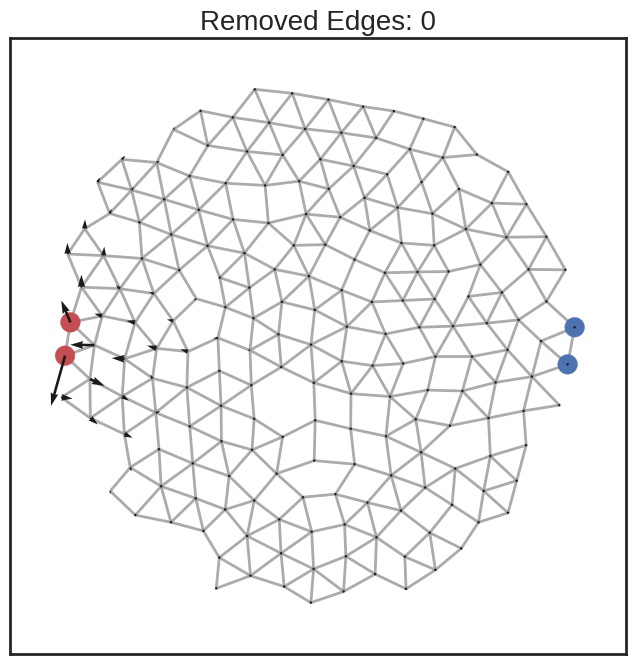

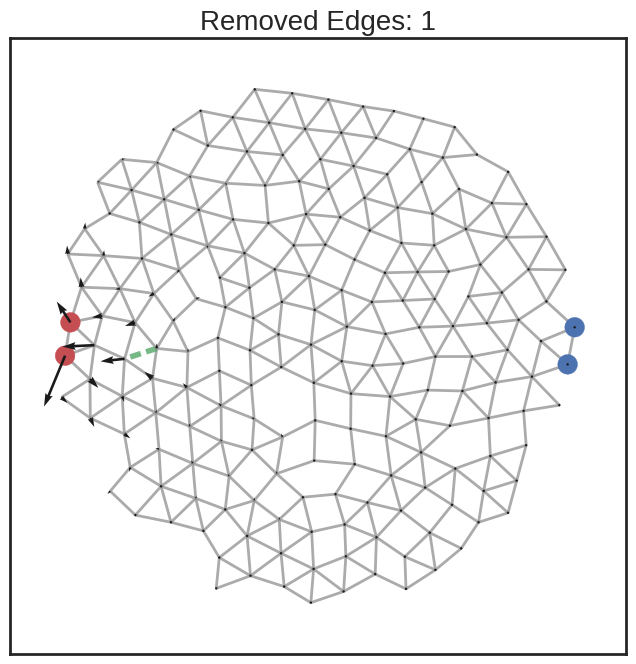

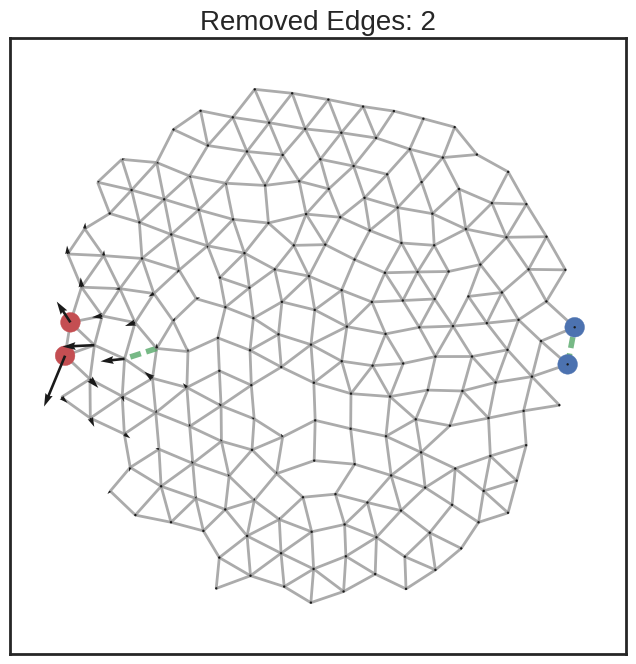

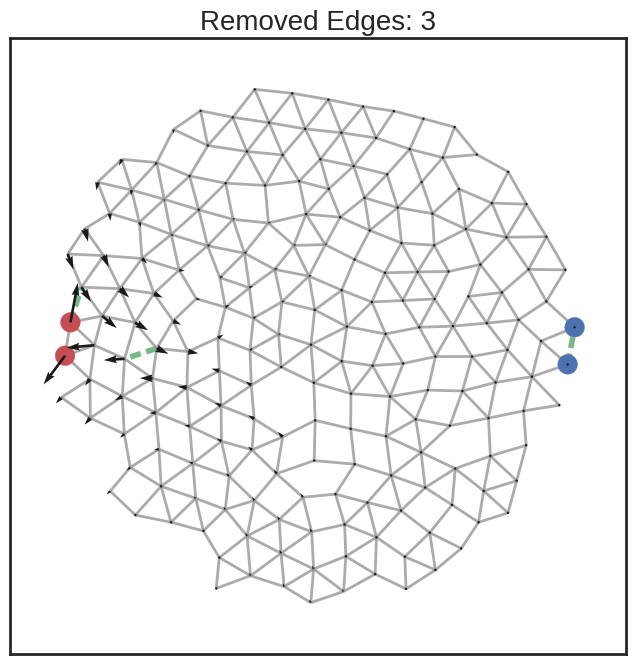

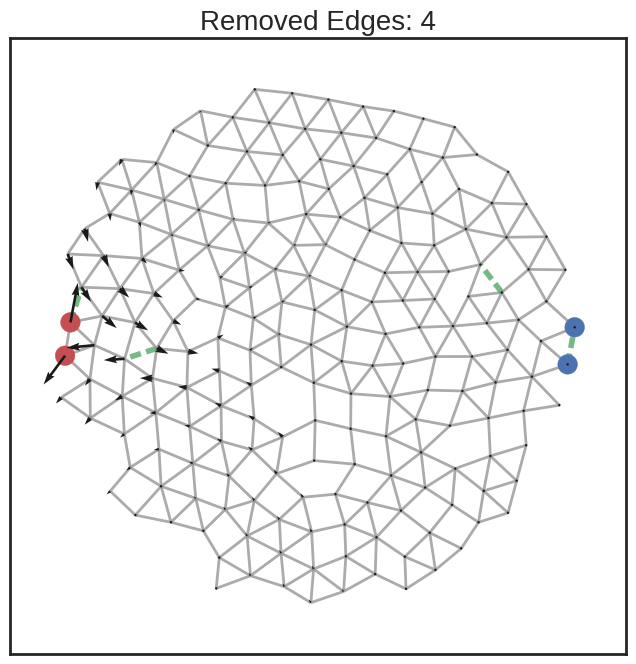

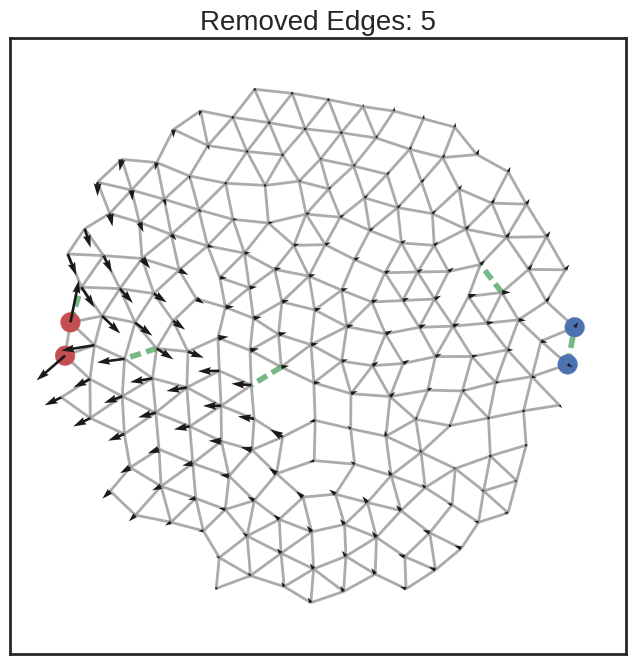

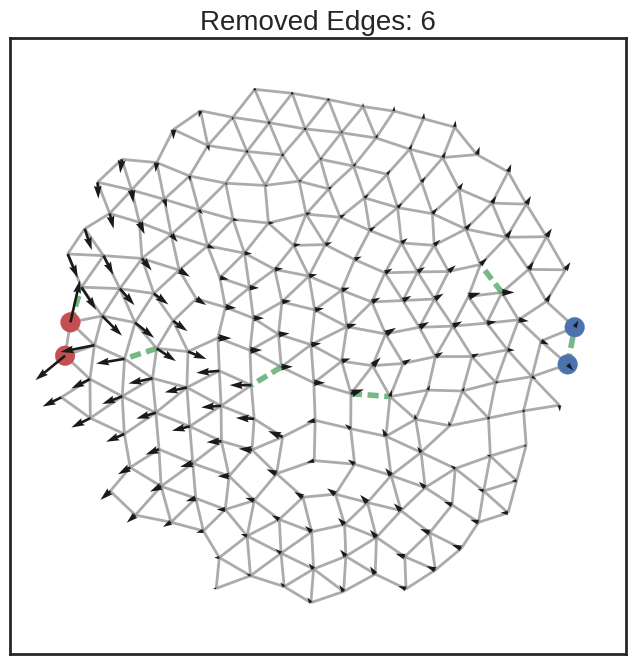

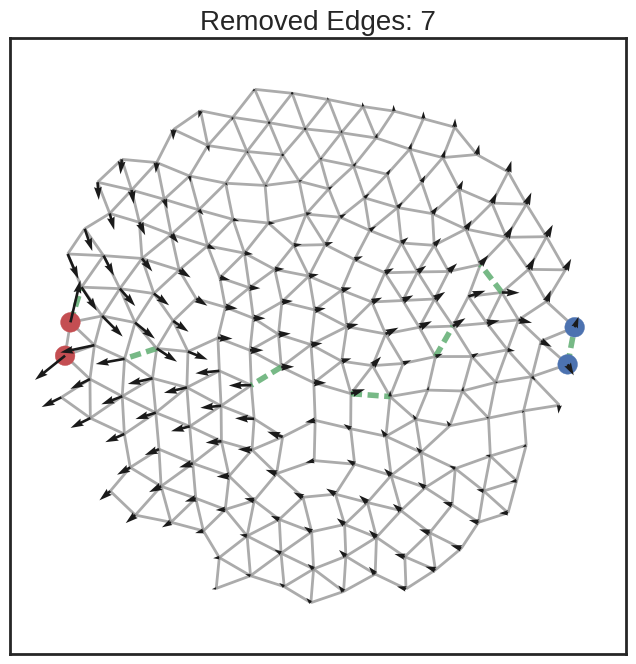

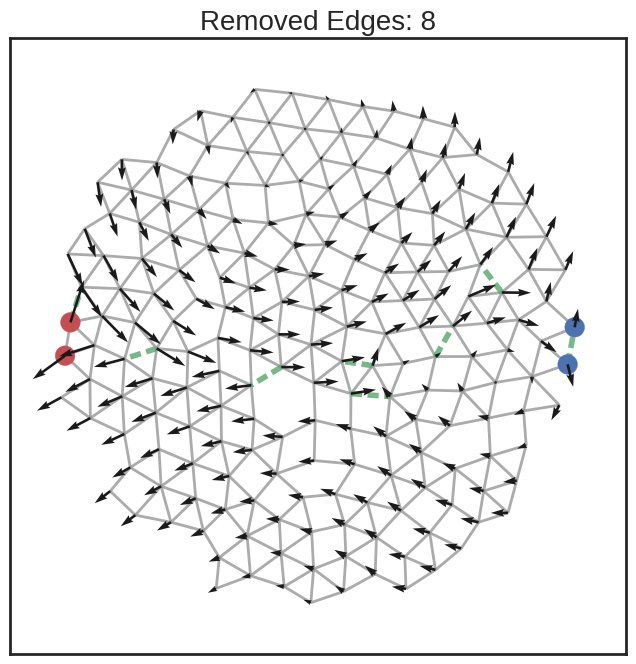

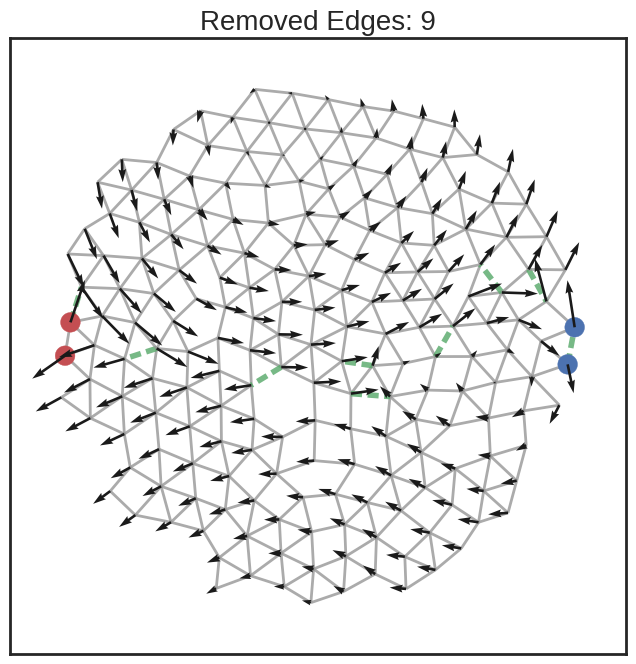

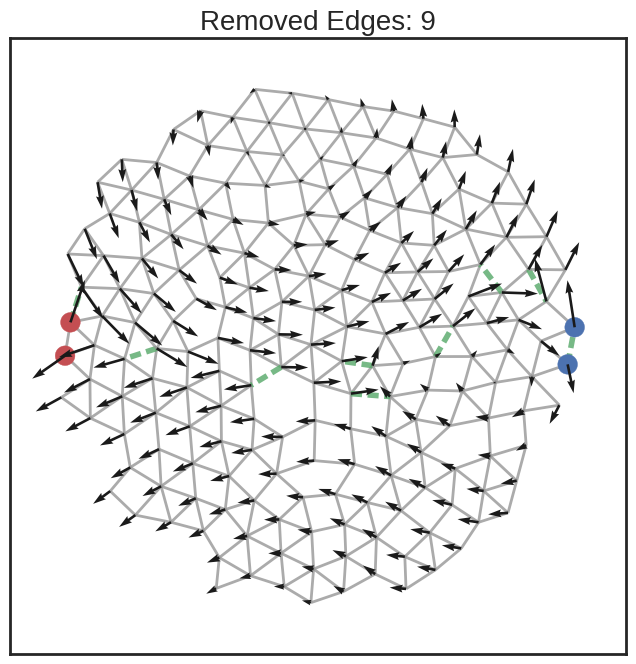

In [33]:
mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='deep')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})


rem_bonds = [137, 420, 330, 362, 334, 445, 351, 49, 367]

K = np.copy(K_max)

disp_list = []
K_list = []

tuner.solver.setIntStrengths(K)
(disp, strain) = tuner.solver.solveDOF()
disp_list.append(disp[0])
K_list.append(np.copy(K))
disp_list.append(disp[0])
K_list.append(np.copy(K))

for b in rem_bonds:
    K[b] = 0.0
    
    tuner.solver.setIntStrengths(K)
    (disp, strain) = tuner.solver.solveDOF()
    disp_list.append(disp[0])
    K_list.append(np.copy(K))

disp_list.append(disp[0])
K_list.append(np.copy(K))

for n in range(len(disp_list)):

    fig = plt.figure(figsize=(8,8))
    ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

    disp = disp_list[n]
    removed = np.where(K_list[n] == 0.0)[0]



    styles = {edge: {} for edge in range(net.NE)}
    for edge in removed:
        styles[edge]['ls'] = (0.0, (2.0,1.0))
        styles[edge]['color'] = 'g'
        styles[edge]['lw'] = 4.0

#     ext = calc_ext(net, disp)
        
#     limit = np.max([np.abs(np.min(ext)), np.abs(np.max(ext))])
#     norm = mcolors.Normalize(vmin=-limit, vmax=limit)
#     # norm = mcolors.Normalize(vmin=np.min(ext), vmax=np.max(ext))
#     cmap = mpl.cm.coolwarm
#     smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

#     for edge in range(net.NE):
#         styles[edge]['color'] = smap.to_rgba(ext[edge])    
    
    nplot.show_network(ax1, net, styles=styles)

    styles = {}
    for i in inodesi[0]:
        styles[i] = {}
        styles[i]['color'] = 'r'
    for i in inodesj[0]:
        styles[i] = {}
        styles[i]['color'] = 'r'

    for i in onodesi[0]:
        styles[i] = {}
        styles[i]['color'] = 'b'
    for i in onodesj[0]:
        styles[i] = {}
        styles[i]['color'] = 'b'

    nplot.show_nodes(ax1, net, styles.keys(), styles=styles)

    nplot.show_vecs(ax1, net, 2.0*disp)

    ax1.set_title("Removed Edges: {}".format(len(removed)), {'fontsize': 20})

    ax1.get_xaxis().set_ticks([])
    ax1.get_yaxis().set_ticks([])

    
#     cax = fig.add_axes([0.925, 0.10, 0.03, 0.80])
#     cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
#                                     norm=norm,
#                                     orientation='vertical')

#     cbar.ax.tick_params(labelsize=16) 
#     cbar.set_label("Extension", fontdict={'fontsize': 20})
    
    plt.savefig("talk_figs/frames/tuned_mech_input_extension_frame{:02d}.png".format(n))


    plt.show()



In [34]:
nplot.createGIF("talk_figs/frames/tuned_mech_input_extension_frame*.png", "{}.gif".format("talk_figs/tuned_mech_input_extension"), delay=50)